In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.metrics import r2_score
from math import sqrt

In [64]:
train = pd.read_csv('df_train_copy')

In [65]:
train = train[['Item_Identifier', 'Item_Weight', 'Item_Fat_Content',
       'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Years_Established']]

train_copy = train.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1)
rf_train = train.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1)
rf_xgb = train_copy = train.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1)

In [6]:
def do_dataset(ip_dataset):

    le = LabelEncoder()
    to_encode = ['Outlet_Size']
    for i in to_encode:
        ip_dataset[i] =le.fit_transform(ip_dataset[i])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)
    print('..........label encoding completed')
    print('dataset size :',ip_dataset.shape)
    
    
    cat_cols = ['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Type']
    dataset = pd.get_dummies(data = ip_dataset, prefix_sep='_', columns = cat_cols, drop_first =True, dtype='int8')
    print('..........dummy variables created')
    print('dataset size :',dataset.shape)
    
    return dataset

In [7]:
def rem_out_isoforest(encoded_ds):
    iso = IsolationForest(contamination = 0.05)
    yhat = iso.fit_predict(encoded_ds)
    mask = yhat != -1
    print(encoded_ds.shape)
    outlier_treated = encoded_ds[mask]
    print(outlier_treated.shape)
    return outlier_treated

In [8]:
def rem_out_isoforest(encoded_ds):
    iso = EllipticEnvelope(contamination = 0.01)
    yhat = iso.fit_predict(encoded_ds)
    mask = yhat != -1
    print(encoded_ds.shape)
    outlier_treated = encoded_ds[mask]
    print(outlier_treated.shape)
    return outlier_treated

### Applying Linear Regression

In [9]:
def run_regression(reg_dataset):
    
    features = reg_dataset.columns[reg_dataset.columns != 'Item_Outlet_Sales']
    
    X =  reg_dataset.loc[:, reg_dataset.columns != 'Item_Outlet_Sales']
    y =  reg_dataset['Item_Outlet_Sales']
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=22)    
    
    lin_reg = LinearRegression(normalize = True)
    lin_reg.fit(X_train,y_train)
    y_pred = lin_reg.predict(X_val)
    
    #plt.figure(figsize=(8,12))
    #sns.barplot(lin_reg.coef_,features)
    print('Intercept : ', lin_reg.intercept_)
    #coef = pd.Series(lin_reg.coef_,features).sort_values()
    #print('---------------- coefficients -------------------') 
    #print(coef) 
    
    df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
    #ax1 = sns.displot(df['Actual'], color = 'red', label = "Actual values")
    #sns.displot(df['Actual'], color = 'blue', label = "Predicted values", ax = ax1)
    
    sns.distplot(df['Actual'], hist=False, rug=True, label = 'Actual')
    sns.distplot(df['Predicted'], hist=False, rug=True, label = 'Pred')
    plt.legend()
    plt.show()
    
    R2   = r2_score(y_val,y_pred)
    MAE  = metrics.mean_absolute_error(y_val,y_pred)
    MSE  = metrics.mean_squared_error(y_val,y_pred)
    RMSE = sqrt(MSE)

    print("R2 : {}, MAE : {}, MSE : {}, RMSE : {}".format(R2, MAE, MSE, RMSE))

In [10]:
reg_train = do_dataset(train_copy)

{'High': 0, 'Medium': 1, 'Small': 2}
..........label encoding completed
dataset size : (8523, 10)
..........dummy variables created
dataset size : (8523, 27)


In [11]:
#reg_train.head()

Intercept :  -1705.639211550219


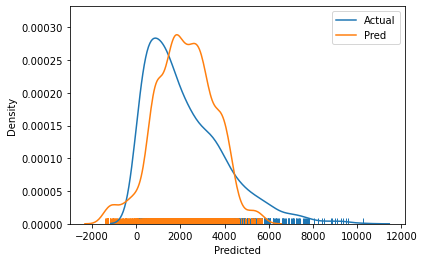

R2 : 0.5395174083066159, MAE : 881.4395234561489, MSE : 1423040.3558265327, RMSE : 1192.9125516258653


In [12]:
run_regression(reg_train)

#### Handling Outliers

outlier handling methods : https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

In [13]:
encoded_train_copy = do_dataset(train_copy)

{0: 0, 1: 1, 2: 2}
..........label encoding completed
dataset size : (8523, 10)
..........dummy variables created
dataset size : (8523, 27)


In [14]:
#isolation forest method

outlier_treated = rem_out_isoforest(encoded_train_copy)

(8523, 27)
(8437, 27)


Intercept :  -1754.7275652583885


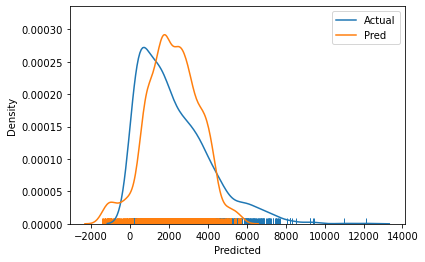

R2 : 0.5523687123027465, MAE : 879.4301879809462, MSE : 1414935.9249597043, RMSE : 1189.5107922838297


In [15]:
run_regression(outlier_treated)

In [16]:
#minimum covariance determinant method

encoded_train_copy2 = do_dataset(train_copy)

{0: 0, 1: 1, 2: 2}
..........label encoding completed
dataset size : (8523, 10)
..........dummy variables created
dataset size : (8523, 27)


In [17]:
outlier_treated2 = rem_out_isoforest(encoded_train_copy2)

(8523, 27)
(8437, 27)


Intercept :  -1690.490794240939


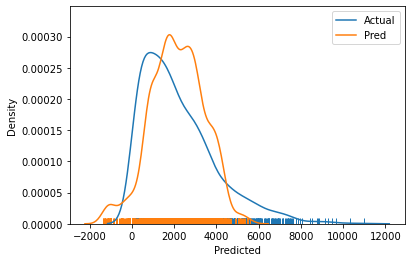

R2 : 0.5468159204106193, MAE : 867.8123443871382, MSE : 1384425.3407588124, RMSE : 1176.6160549469025


In [18]:
run_regression(outlier_treated2)

considering the above 3 methods, isolation forest method has some slight advantage over the other 2. 

### Applying Random Forest

In [19]:
rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=20, n_jobs=4, random_state=22)

For this I am not going to handle outliers or to do onehot encoding as tree based algorithms manages them well

In [20]:
train_copy.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Years_Established
0,9.30,Low Fat,0.016047,Dairy,249.8092,1,Tier 1,Supermarket Type1,3735.1380,22
1,5.92,Regular,0.019278,Soft Drinks,48.2692,1,Tier 3,Supermarket Type2,443.4228,12
2,17.50,Low Fat,0.016760,Meat,141.6180,1,Tier 1,Supermarket Type1,2097.2700,22
3,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,1,Tier 3,Grocery Store,732.3800,23
4,8.93,Low Fat,0.066132,Household,53.8614,0,Tier 3,Supermarket Type1,994.7052,34


In [21]:
le = LabelEncoder()
to_encode = ['Outlet_Size','Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type' ]
for i in to_encode:
    rf_train[i] =le.fit_transform(rf_train[i])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

{'High': 0, 'Medium': 1, 'Small': 2}
{'Low Fat': 0, 'Regular': 1}
{'Baking Goods': 0, 'Breads': 1, 'Breakfast': 2, 'Canned': 3, 'Dairy': 4, 'Frozen Foods': 5, 'Fruits and Vegetables': 6, 'Hard Drinks': 7, 'Health and Hygiene': 8, 'Household': 9, 'Meat': 10, 'Others': 11, 'Seafood': 12, 'Snack Foods': 13, 'Soft Drinks': 14, 'Starchy Foods': 15}
{0: 0, 1: 1, 2: 2}
{'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2}
{'Grocery Store': 0, 'Supermarket Type1': 1, 'Supermarket Type2': 2, 'Supermarket Type3': 3}


In [23]:
X =  rf_train.loc[:, rf_train.columns != 'Item_Outlet_Sales']
y =  rf_train.loc[:, rf_train.columns == 'Item_Outlet_Sales']

In [24]:
sc = StandardScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=22) 

In [25]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=20, n_estimators=200,
                      n_jobs=4, random_state=22)

In [26]:
y_pred = rf.predict(X_val)

<AxesSubplot:>

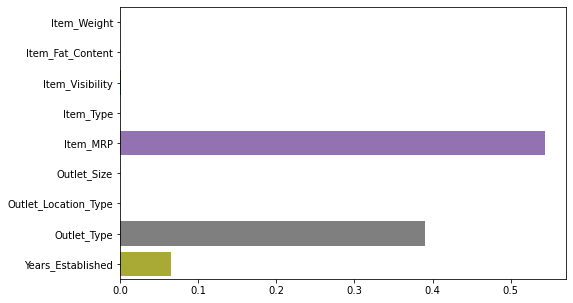

In [27]:
features = rf_train.columns[rf_train.columns != 'Item_Outlet_Sales']

#coef_rf = pd.Series(rf.feature_importances_, features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(rf.feature_importances_,features)

In [30]:
#do we need to convert labels into numbers before applying RF
#what is cross validation
y_val = y_val.flatten()

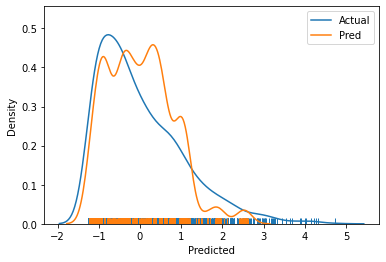

In [31]:
df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})

sns.distplot(df['Actual'], hist=False, rug=True, label = 'Actual')
sns.distplot(df['Predicted'], hist=False, rug=True, label = 'Pred')
plt.legend()
plt.show()

In [ ]:
#pip install tpot

### Trying with AutoML 

while doing some searching, found this autoML package named tpot. This will automatically look for the best model (tree based) and output the optimum algorithm with hyperparameters.

In [32]:
import tpot
print('tpot: %s' % tpot.__version__)
from sklearn.model_selection import RepeatedKFold
from tpot import TPOTRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler

tpot: 0.11.7


In [33]:
df = pd.read_csv('df_train_copy')

df = df[['Item_Identifier', 'Item_Weight', 'Item_Fat_Content',
       'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Years_Established']]

df = df.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1)

In [34]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Years_Established
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380,22
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228,12
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700,22
3,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,Medium,Tier 3,Grocery Store,732.3800,23
4,8.93,Low Fat,0.066132,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052,34


In [35]:
le = LabelEncoder()
to_encode = ['Outlet_Size','Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Type']
for i in to_encode:
    df[i] =le.fit_transform(df[i])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)
print('..........label encoding completed')
print('dataset size :',df.shape)

{'High': 0, 'Medium': 1, 'Small': 2}
{'Low Fat': 0, 'Regular': 1}
{'Baking Goods': 0, 'Breads': 1, 'Breakfast': 2, 'Canned': 3, 'Dairy': 4, 'Frozen Foods': 5, 'Fruits and Vegetables': 6, 'Hard Drinks': 7, 'Health and Hygiene': 8, 'Household': 9, 'Meat': 10, 'Others': 11, 'Seafood': 12, 'Snack Foods': 13, 'Soft Drinks': 14, 'Starchy Foods': 15}
{'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2}
{'Grocery Store': 0, 'Supermarket Type1': 1, 'Supermarket Type2': 2, 'Supermarket Type3': 3}
..........label encoding completed
dataset size : (8523, 10)


In [36]:
X =  df.loc[:, df.columns != 'Item_Outlet_Sales']
y =  df.loc[:, df.columns == 'Item_Outlet_Sales']

In [37]:
sc = StandardScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=22)

In [39]:
#define the cross validation 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [40]:
# define search
model = TPOTRegressor(generations=5, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, 
                      random_state=1, n_jobs=-1)

In [41]:
#model.fit(X_train, y_train)
#export the best model
#model.export('tpot_insurance_best_model.py')

ADABoost classifier for regression defines our dataset best. Read : https://www.datacamp.com/community/tutorials/adaboost-classifier-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-390929969673:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1009919&gclid=CjwKCAjwp_GJBhBmEiwALWBQk7nPPz1YPJntI5wqtI8xAZ3HJ8DHOaTD-Az7L_rD6sJ_DMeFfxCtQxoCap8QAvD_BwE

In [42]:
from sklearn.ensemble import AdaBoostRegressor

In [43]:
reg = AdaBoostRegressor(random_state=0, n_estimators=100)

In [44]:
reg.fit(X, y)

AdaBoostRegressor(n_estimators=100, random_state=0)

ada_pred = reg.predict(X_val)
ada_pred

In [46]:
print(y_val.shape)
print(ada_pred.shape)

(1705, 1)
(1705,)


In [47]:
y_val = y_val.flatten()

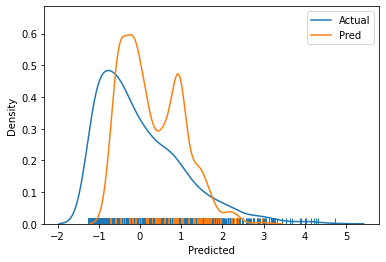

In [48]:
df = pd.DataFrame({'Actual': y_val, 'Predicted': ada_pred})

sns.distplot(df['Actual'], hist=False, rug=True, label = 'Actual')
sns.distplot(df['Predicted'], hist=False, rug=True, label = 'Pred')
plt.legend()
plt.show()

seems like for random forest the results was better - Need to find why

### Applying XGB 

In [77]:
# normally XGB performs well when compared to ADABoost. Let's just give a try